# NAFLD detection using RNA-Seq data


__Content creators:__  Mahdi Anvari, Sadegh Rizi

**University of Tehran, Department of Biotechnology**

In this part, we need to perform a regression task to predict the age of samples based on their gene expression profiles and clinical data.

We will then split the dataset based on sex, repeat the regression task, and compare the results between the groups.

# Q4 - Python section ##

In [24]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LassoCV
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold

In [2]:
# Load Data
normal_counts = pd.read_csv('Normal.counts.voom.csv')
meta_data = pd.read_csv('meta_data.csv')

In [3]:
normal_counts.head()

,gene,DLDR_0001,DLDR_0002,DLDR_0003,DLDR_0004,DLDR_0005,DLDR_0006,DLDR_0007,DLDR_0008,DLDR_0009,...,DLDR_0183,DLDR_0184,DLDR_0185,DLDR_0186,DLDR_0187,DLDR_0188,DLDR_0189,DLDR_0190,DLDR_0191,DLDR_0192
0,ENSG00000000003,5.965571,5.741587,5.996891,5.551919,6.430237,6.234619,6.071503,6.441882,5.752712,...,6.304802,6.576246,6.735760,6.344234,6.608924,6.480745,6.360397,6.367705,6.604050,6.514539
1,ENSG00000000005,1.612375,2.147793,0.418542,0.702492,1.215978,0.920810,0.458163,0.927224,1.089389,...,-0.031596,-1.091275,-0.942637,-0.026585,-0.757399,-1.083676,0.886550,-0.902201,-0.865036,-1.588749
2,ENSG00000000419,4.133821,4.120969,4.086129,4.116240,4.393797,4.390909,4.148242,4.554655,4.203819,...,4.176599,4.244459,4.342765,4.179319,4.274450,4.361634,4.093280,4.148010,4.351489,3.859711
3,ENSG00000000457,4.111056,3.922234,3.964871,3.978350,4.018235,3.864521,4.263119,3.896271,4.139546,...,4.378342,4.453838,4.685598,4.438796,4.042577,4.313540,4.205119,4.506058,4.072137,4.341988
4,ENSG00000000460,4.150662,3.732756,3.634637,3.853979,3.614220,3.500857,4.000565,4.016287,3.904500,...,2.974209,3.720038,4.640011,3.814717,2.126408,3.120196,3.336802,3.982071,3.143138,2.741172


In [4]:
normal_counts.shape

(17396, 193)

In [5]:
meta_data.head()

,Patient_ID,SEX,BMI_surg,Age,Run,Diabet,Simplified_class
0,DLDR_0001,Female,35.214555,55,SRR8378590,Non Diabetic,Normal
1,DLDR_0002,Female,39.421748,47,SRR8378589,Diabetic,Normal
2,DLDR_0003,Male,48.758108,46,SRR8378432,Non Diabetic,Normal
3,DLDR_0004,Female,41.822607,36,SRR8378431,Non Diabetic,Normal
4,DLDR_0005,Female,53.582192,54,SRR8378434,Non Diabetic,Normal


In [6]:
meta_data.shape

(192, 7)

In [13]:
print("Number of Female samples: ", meta_data['SEX'].to_list().count("Female"))
print("Number of Male samples: ", meta_data['SEX'].to_list().count("Male"))

Number of Female samples:  154
Number of Male samples:  38


To include our clinical data, we need to perform some preprocessing steps. For categorical data, we will use one-hot encoding, and for continuous data, we will apply normalization.

In [14]:
# One-Hot Encoding for categorical features
categorical_features = ['SEX', 'Diabet']
ohe = OneHotEncoder()
# Standardize continuous variables
numerical_features = ['BMI_surg', 'Age']
scaler = StandardScaler()
# Preprocess clinical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_features),
        ('cat', ohe, categorical_features)])

In [15]:
clinical_data = preprocessor.fit_transform(meta_data)

In [16]:
clinical_data = pd.DataFrame(clinical_data).iloc[:, [0, 2, 4]]
clinical_data.columns = ['BMI_surg', 'Sex', 'Diabet']

In [17]:
clinical_data

,BMI_surg,Sex,Diabet
0,-1.308155,1.0,0.0
1,-0.857325,1.0,1.0
2,0.143131,0.0,0.0
3,-0.600056,1.0,0.0
4,0.660065,1.0,0.0
...,...,...,...
187,-0.772196,0.0,1.0
188,0.284524,1.0,0.0
189,6.161411,0.0,1.0
190,0.007788,1.0,0.0


In [18]:
gene_names = normal_counts.iloc[:,0]
gene_names.at[17396] = 'BMI_surg'
gene_names.at[17397] = 'SEX'
gene_names.at[17398] = 'Diabet'

In [19]:
gene_names

0        ENSG00000000003
1        ENSG00000000005
2        ENSG00000000419
3        ENSG00000000457
4        ENSG00000000460
              ...       
17394    ENSG00000273274
17395    ENSG00000273294
17396           BMI_surg
17397                SEX
17398             Diabet
Name: gene, Length: 17399, dtype: object

Now, let's combine our gene expression data with clinical data

In [20]:
combined_data = np.hstack((normal_counts.iloc[0:,1:].T, clinical_data))
df_deg = pd.DataFrame(combined_data)
df_deg.columns = gene_names

In [21]:
df_deg

gene,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000272658,ENSG00000272869,ENSG00000273079,ENSG00000273173,ENSG00000273259,ENSG00000273274,ENSG00000273294,BMI_surg,SEX,Diabet
0,5.965571,1.612375,4.133821,4.111056,4.150662,2.975845,11.005488,4.405768,6.825329,4.221450,...,1.365460,0.691230,5.637483,-0.005377,1.675800,2.683536,-0.339797,-1.308155,1.0,0.0
1,5.741587,2.147793,4.120969,3.922234,3.732756,3.199989,10.860700,3.895350,6.453687,4.218183,...,0.935490,1.004202,5.975612,0.532134,1.555218,2.926666,0.435919,-0.857325,1.0,1.0
2,5.996891,0.418542,4.086129,3.964871,3.634637,2.949733,10.934025,4.282577,6.437658,3.736947,...,0.675699,0.943633,5.531648,-0.184123,2.391906,2.260662,-0.691083,0.143131,0.0,0.0
3,5.551919,0.702492,4.116240,3.978350,3.853979,2.991061,10.760445,4.297722,6.710840,4.003661,...,0.702492,0.431190,5.571799,-0.034474,1.639298,2.341393,0.096771,-0.600056,1.0,0.0
4,6.430237,1.215978,4.393797,4.018235,3.614220,2.836130,11.491427,4.405558,7.437655,4.377965,...,0.898496,0.085581,5.636848,-1.216981,1.974160,1.351861,-0.079478,0.660065,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,6.480745,-1.083676,4.361634,4.313540,3.120196,1.941859,11.451981,4.556052,7.183779,5.066071,...,0.632531,-0.431600,2.616763,1.063165,1.941859,-2.306069,0.632531,-0.772196,0.0,1.0
188,6.360397,0.886550,4.093280,4.205119,3.336802,2.911496,11.658711,4.315153,7.384726,4.627703,...,-0.147398,-1.080284,2.975985,0.589568,2.754906,-0.839275,-0.016153,0.284524,1.0,0.0
189,6.367705,-0.902201,4.148010,4.506058,3.982071,2.202136,11.864397,4.348255,7.326297,4.528530,...,0.048889,-1.108652,3.218814,-0.416774,2.246191,-1.639167,0.145105,6.161411,0.0,1.0
190,6.604050,-0.865036,4.351489,4.072137,3.143138,4.037476,11.782524,4.358527,8.468526,5.013154,...,-1.154543,-0.624028,2.050571,-1.517113,2.084923,-4.324468,0.067849,0.007788,1.0,0.0


Let's split our data and labels to train and test sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_deg, meta_data['Age'], test_size=0.2, random_state = 10101)

First, we applied a variance threshold to filter out features that do not have sufficient variation.

In [25]:
threshold = 0.8
selector = VarianceThreshold(threshold)
filtered_data = selector.fit_transform(X_train)
selected_features = X_train.columns[selector.get_support()]
X_train_filtered = pd.DataFrame(filtered_data, columns=selected_features)

In [26]:
X_train_filtered.shape

(153, 5229)

Next, we performed LASSO to extract the most relevant features for this task.

In [21]:
lasso = LassoCV(cv=5).fit(X_train_filtered, y_train)
# Extract the non-zero coefficients
important_genes = X_train_filtered.columns[(lasso.coef_ != 0)]

In [22]:
important_genes

Index(['ENSG00000001630', 'ENSG00000007001', 'ENSG00000011083',
       'ENSG00000024526', 'ENSG00000064205', 'ENSG00000071909',
       'ENSG00000086548', 'ENSG00000091129', 'ENSG00000103154',
       'ENSG00000104369', 'ENSG00000109182', 'ENSG00000115009',
       'ENSG00000115457', 'ENSG00000129824', 'ENSG00000131080',
       'ENSG00000134184', 'ENSG00000141668', 'ENSG00000144229',
       'ENSG00000151025', 'ENSG00000152726', 'ENSG00000152779',
       'ENSG00000162391', 'ENSG00000164266', 'ENSG00000165246',
       'ENSG00000166923', 'ENSG00000170160', 'ENSG00000171496',
       'ENSG00000171747', 'ENSG00000181333', 'ENSG00000182771',
       'ENSG00000182870', 'ENSG00000184674', 'ENSG00000184698',
       'ENSG00000189266', 'ENSG00000221890', 'ENSG00000236882',
       'ENSG00000244694', 'ENSG00000255798', 'ENSG00000256618'],
      dtype='object', name='gene')

In [23]:
len(important_genes)

39

In [24]:
X_train[important_genes]

gene,ENSG00000001630,ENSG00000007001,ENSG00000011083,ENSG00000024526,ENSG00000064205,ENSG00000071909,ENSG00000086548,ENSG00000091129,ENSG00000103154,ENSG00000104369,...,ENSG00000182771,ENSG00000182870,ENSG00000184674,ENSG00000184698,ENSG00000189266,ENSG00000221890,ENSG00000236882,ENSG00000244694,ENSG00000255798,ENSG00000256618
9,-0.579836,5.686951,2.307689,0.467470,1.067862,1.780060,0.036835,3.584736,3.075516,-1.027295,...,2.052432,2.254740,4.527294,-0.399264,0.467470,0.722727,6.884506,0.798676,2.432137,6.505504
16,0.467219,3.764056,3.043866,2.238594,2.238594,3.534050,2.575022,3.603591,3.027090,1.223948,...,2.957966,2.575022,3.659086,0.894640,-0.142835,2.267449,5.158060,2.209151,-0.690322,7.458252
149,-1.395729,6.789909,-5.096169,-1.008706,-2.288814,-0.703852,-0.238188,0.685191,2.985980,-1.636737,...,2.355042,-5.096169,3.889673,-2.288814,-2.774241,1.503744,4.096124,-1.395729,-5.096169,4.302575
63,-0.910103,2.403314,2.927247,1.445378,1.770618,2.803334,1.991119,2.777221,3.635429,0.933171,...,2.533816,2.549329,5.584576,0.674859,-4.997566,1.822613,5.936862,1.411825,1.541593,6.323799
41,0.522448,6.611324,-4.969405,-4.969405,-1.268966,-4.969405,-1.509974,0.456859,3.235166,-4.969405,...,1.096684,-3.384443,-4.969405,-2.647477,1.659951,-2.647477,8.626668,-2.647477,-2.162050,6.275553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,-0.105322,7.730441,-5.149716,-5.149716,-3.564753,-0.901788,-5.149716,-1.242825,1.536785,-2.827788,...,-2.827788,-3.564753,4.975697,-5.149716,0.827564,0.059737,7.257286,-1.242825,-1.062253,9.595696
185,-0.823052,7.831961,-3.486017,-1.370540,-5.070979,-3.486017,-2.749051,0.601446,1.774511,-1.901054,...,2.047962,-5.070979,-5.070979,-1.611548,2.005836,-0.316092,4.631193,-2.263624,2.148189,8.637566
178,-0.983901,7.563422,-2.568864,-2.568864,-1.831898,-4.153826,-4.153826,-0.246936,1.868542,-1.831898,...,0.800370,-1.831898,3.782812,-2.568864,0.800370,-0.246936,7.818077,-1.831898,-2.568864,7.130998
181,-0.255283,4.830607,-5.010171,-5.010171,-2.688243,-2.688243,-2.688243,-1.550739,2.407682,-2.202816,...,-1.550739,-3.425208,3.644465,-5.010171,1.619186,-1.840246,4.988419,0.481682,-1.840246,9.887060


In [25]:
X_test[important_genes].shape

(39, 39)

It's time for regression. I have used three types of regressors in this part to ensure consistency. These regressors are well-established in machine learning and are well-suited for this task. The regressors used are: Linear Regression, Ridge Regression, and ElasticNet Regression.

In [52]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=0.5),
    "ElasticNet Regression": ElasticNet(alpha=1.0, l1_ratio=0.5),
}

results = {}

for name, model in models.items():
    model.fit(X_train_filtered[important_genes], y_train)
    y_pred = model.predict(X_test[important_genes])
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {
        "MSE": mse,
        "R²": r2
    }

for model_name, metrics in results.items():
    print(f"{model_name}:\n\tMSE: {metrics['MSE']}\n\tR²: {metrics['R²']}\n")

Linear Regression:
	MSE: 109.75763313259237
	R²: 0.14127465204431466

Ridge Regression:
	MSE: 109.66346309043713
	R²: 0.14201142268986122

ElasticNet Regression:
	MSE: 98.05173665922788
	R²: 0.23285962645861957



Let's split the dataset based on sex, repeat the regression task, and compare the results between the groups.

### Female

In [27]:
female_df_deg = df_deg[df_deg['SEX'] == 1]

In [28]:
female_df_deg.shape

(154, 17399)

In [29]:
female_meta_data = meta_data[meta_data['SEX'] == 'Female']

In [30]:
female_meta_data.shape

(154, 7)

Let's split our data and labels to train and test sets

In [31]:
X_train, X_test, y_train, y_test = train_test_split(female_df_deg, female_meta_data, test_size=0.2, random_state = 10101)

First, we applied a variance threshold to filter out features that do not have sufficient variation.

In [32]:
threshold = 0.8
selector = VarianceThreshold(threshold)
filtered_data = selector.fit_transform(X_train)
selected_features = X_train.columns[selector.get_support()]
X_train_filtered = pd.DataFrame(filtered_data, columns=selected_features)

In [33]:
X_train_filtered.shape

(123, 5223)

Next, we performed LASSO to extract the most relevant features for this task.

In [33]:
lasso = LassoCV(cv=5).fit(X_train_filtered, y_train['Age'])
# Extract the non-zero coefficients
female_important_genes = X_train_filtered.columns[(lasso.coef_ != 0)]

In [34]:
female_important_genes

Index(['ENSG00000007001', 'ENSG00000070193', 'ENSG00000086548',
       'ENSG00000100867', 'ENSG00000104044', 'ENSG00000104435',
       'ENSG00000112852', 'ENSG00000128313', 'ENSG00000129824',
       'ENSG00000131080', 'ENSG00000132872', 'ENSG00000134121',
       'ENSG00000134640', 'ENSG00000134668', 'ENSG00000139515',
       'ENSG00000151962', 'ENSG00000161973', 'ENSG00000162391',
       'ENSG00000162426', 'ENSG00000164266', 'ENSG00000165246',
       'ENSG00000166206', 'ENSG00000169876', 'ENSG00000171747',
       'ENSG00000174226', 'ENSG00000179674', 'ENSG00000180440',
       'ENSG00000182256', 'ENSG00000182771', 'ENSG00000196844',
       'ENSG00000198885', 'ENSG00000205358', 'ENSG00000206077',
       'ENSG00000213088', 'ENSG00000221890', 'ENSG00000223609',
       'ENSG00000236882', 'ENSG00000237693', 'ENSG00000239839',
       'ENSG00000250361', 'ENSG00000251209', 'ENSG00000255798',
       'ENSG00000256618', 'ENSG00000258484'],
      dtype='object', name='gene')

In [35]:
len(female_important_genes)

44

In [34]:
female_df_deg[female_important_genes]

gene,ENSG00000007001,ENSG00000070193,ENSG00000086548,ENSG00000100867,ENSG00000104044,ENSG00000104435,ENSG00000112852,ENSG00000128313,ENSG00000129824,ENSG00000131080,...,ENSG00000221890,ENSG00000223609,ENSG00000236882,ENSG00000237693,ENSG00000239839,ENSG00000250361,ENSG00000251209,ENSG00000255798,ENSG00000256618,ENSG00000258484
0,3.061454,0.346095,2.234674,2.830128,1.956820,1.440422,0.809067,0.265925,-3.278396,2.758693,...,1.706497,0.181036,3.960009,1.245166,3.000828,1.019285,0.751351,2.007006,6.124616,-0.219502
1,8.213882,0.863340,2.961642,3.886277,2.372354,1.460581,0.863340,1.132527,-2.837100,2.890821,...,1.952977,0.787391,7.135880,2.020881,-0.334599,0.935490,1.460581,1.600305,6.772079,-0.721623
3,9.549683,0.096771,2.112367,2.341393,1.503946,1.354568,1.127797,0.617603,-4.426791,2.314676,...,1.913059,-0.726352,5.746886,1.127797,-0.339329,-0.339329,0.431190,-0.967360,6.704422,-0.339329
4,2.541464,0.085581,1.142914,1.746493,0.490838,0.430717,0.161530,0.005411,-5.123872,2.555608,...,0.233680,-0.265891,5.103744,0.302393,-0.265891,-0.600310,0.657488,-0.875945,5.328369,0.430717
5,4.478528,0.350495,1.645951,2.773706,1.414625,0.920810,0.435384,-0.445972,-4.693899,3.132649,...,1.681140,-0.606437,6.590925,-0.050043,-2.371971,0.060988,1.188744,2.486010,6.479153,-1.886544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,7.831961,-0.678662,-2.749051,-3.486017,-1.901054,-3.486017,-2.263624,-2.263624,-5.070979,-5.070979,...,-0.316092,-5.070979,4.631193,-5.070979,-0.427123,-2.749051,-0.427123,2.148189,8.637566,-1.901054
186,7.730441,-2.342361,-5.149716,2.584994,-2.827788,-1.979791,-1.062253,-5.149716,-3.564753,-0.901788,...,0.059737,-3.564753,7.257286,-3.564753,-1.979791,-2.827788,-2.827788,-1.062253,9.595696,-1.979791
188,7.990447,-0.632825,-4.539715,1.241645,-4.539715,-2.217787,-2.954753,-0.839275,2.201752,0.952138,...,-1.732360,-4.539715,6.416661,-0.632825,1.903228,-2.954753,0.504679,-0.839275,9.543349,-0.839275
190,4.256733,-2.002540,-1.517113,4.977028,-2.002540,-2.739505,-1.517113,-0.624028,-4.324468,-0.865036,...,0.067849,-2.002540,6.016495,-4.324468,1.942319,-2.739505,-0.865036,-0.417577,9.142755,-2.739505


It's time for regression. I have used three types of regressors in this part to ensure consistency. These regressors are well-established in machine learning and are well-suited for this task. The regressors used are: Linear Regression, Ridge Regression, and ElasticNet Regression.

In [56]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "ElasticNet Regression": ElasticNet(alpha=1.0, l1_ratio=0.5),
}

results = {}

for name, model in models.items():
    model.fit(X_train_filtered[female_important_genes], y_train['Age'])
    y_pred = model.predict(X_test[female_important_genes])

    mse = mean_squared_error(y_test['Age'], y_pred)
    r2 = r2_score(y_test['Age'], y_pred)
    results[name] = {
        "MSE": mse,
        "R²": r2
    }

for model_name, metrics in results.items():
    print(f"{model_name}:\n\tMSE: {metrics['MSE']}\n\tR²: {metrics['R²']}\n")

Linear Regression:
	MSE: 88.31876196989404
	R²: 0.3969937886987882

Ridge Regression:
	MSE: 88.56495689237829
	R²: 0.39531286536904964

ElasticNet Regression:
	MSE: 97.7445429895872
	R²: 0.3326382160609207



### Male

In [34]:
male_df_deg = df_deg[df_deg['SEX'] == 0]

In [35]:
male_df_deg.shape

(38, 17399)

In [36]:
male_meta_data = meta_data[meta_data['SEX'] == 'Male']

In [37]:
male_meta_data.shape

(38, 7)

Let's split our data and labels to train and test sets

In [38]:
X_train, X_test, y_train, y_test = train_test_split(male_df_deg, male_meta_data, test_size=0.2, random_state = 10101)

First, we applied a variance threshold to filter out features that do not have sufficient variation.

In [39]:
threshold = 0.8
selector = VarianceThreshold(threshold)
filtered_data = selector.fit_transform(X_train)
selected_features = X_train.columns[selector.get_support()]
X_train_filtered = pd.DataFrame(filtered_data, columns=selected_features)

In [40]:
X_train_filtered.shape

(30, 5016)

Next, we performed LASSO to extract the most relevant features for this task.

In [45]:
lasso = LassoCV(cv=5).fit(X_train_filtered, y_train['Age'])
# Extract the non-zero coefficients
male_important_genes = X_train_filtered.columns[(lasso.coef_ != 0)]

In [42]:
male_important_genes

Index(['ENSG00000091138', 'ENSG00000095596', 'ENSG00000106236',
       'ENSG00000122121', 'ENSG00000131080', 'ENSG00000134184',
       'ENSG00000140379', 'ENSG00000141668', 'ENSG00000147257',
       'ENSG00000152726', 'ENSG00000168398', 'ENSG00000184674',
       'ENSG00000198074', 'ENSG00000215700', 'ENSG00000235098',
       'ENSG00000235961', 'ENSG00000244694'],
      dtype='object', name='gene')

In [43]:
len(male_important_genes)

17

In [44]:
X_test[male_important_genes].shape

(8, 17)

It's time for regression. I have used three types of regressors in this part to ensure consistency. These regressors are well-established in machine learning and are well-suited for this task. The regressors used are: Linear Regression, Ridge Regression, and ElasticNet Regression.

In [48]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "ElasticNet Regression": ElasticNet(alpha=1.0, l1_ratio=0.5),
}

results = {}

for name, model in models.items():
    model.fit(X_train_filtered[male_important_genes], y_train['Age'])
    y_pred = model.predict(X_test[male_important_genes])

    mse = mean_squared_error(y_test['Age'], y_pred)
    r2 = r2_score(y_test['Age'], y_pred)
    results[name] = {
        "MSE": mse,
        "R²": r2
    }

for model_name, metrics in results.items():
    print(f"{model_name}:\n\tMSE: {metrics['MSE']}\n\tR²: {metrics['R²']}\n")

Linear Regression:
	MSE: 120.18807385165366
	R²: -0.6186945973286688

Ridge Regression:
	MSE: 121.76068452045129
	R²: -0.639874538995977

ElasticNet Regression:
	MSE: 132.0734434710684
	R²: -0.7787669154352648



So far, we have obtained only a single result for each regressor, but these results are not statistically valid. To test for reproducibility, we have put the entire process into a loop to run it 10 times.

In [61]:
# Load Data
normal_counts = pd.read_csv('Normal.counts.voom.csv')
meta_data = pd.read_csv('meta_data.csv')

categorical_features = ['SEX', 'Diabet']
ohe = OneHotEncoder()
numerical_features = ['BMI_surg', 'Age']
scaler = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_features),
        ('cat', ohe, categorical_features)])
clinical_data = preprocessor.fit_transform(meta_data)
clinical_data = pd.DataFrame(clinical_data).iloc[:, [0, 2, 4]]
clinical_data.columns = ['BMI_surg', 'Sex', 'Diabet']
gene_names = normal_counts.iloc[:,0]
gene_names.at[17396] = 'BMI_surg'
gene_names.at[17397] = 'SEX'
gene_names.at[17398] = 'Diabet'

combined_data = np.hstack((normal_counts.iloc[0:,1:].T, clinical_data))
df_deg = pd.DataFrame(combined_data)
df_deg.columns = gene_names

LR_R2s = []
LR_MSEs = []
f_LR_R2s = []
f_LR_MSEs = []
m_LR_R2s = []
m_LR_MSEs = []

RR_R2s = []
RR_MSEs = []
f_RR_R2s = []
f_RR_MSEs = []
m_RR_R2s = []
m_RR_MSEs = []

ENR_R2s = []
ENR_MSEs = []
f_ENR_R2s = []
f_ENR_MSEs = []
m_ENR_R2s = []
m_ENR_MSEs = []

for i in range(10):
    print('iteration',i)
    X_train, X_test, y_train, y_test = train_test_split(df_deg, meta_data['Age'], test_size=0.2, random_state = i)
    threshold = 0.8
    selector = VarianceThreshold(threshold)
    filtered_data = selector.fit_transform(X_train)
    selected_features = X_train.columns[selector.get_support()]
    X_train_filtered = pd.DataFrame(filtered_data, columns=selected_features)
    lasso = LassoCV(cv=5).fit(X_train_filtered, y_train)
    # Extract the non-zero coefficients
    important_genes = X_train_filtered.columns[(lasso.coef_ != 0)]

    # Linear Regression
    LR_model = LinearRegression()
    LR_model.fit(X_train_filtered[important_genes], y_train)
    y_pred_LR = LR_model.predict(X_test[important_genes])
    LR_MSE = mean_squared_error(y_test, y_pred_LR)
    LR_R2 = r2_score(y_test, y_pred_LR)
    LR_MSEs.append(LR_MSE)
    LR_R2s.append(LR_R2)

    # Ridge Regression
    RR_model = Ridge(alpha=0.5)
    RR_model.fit(X_train_filtered[important_genes], y_train)
    y_pred_RR = RR_model.predict(X_test[important_genes])
    RR_MSE = mean_squared_error(y_test, y_pred_RR)
    RR_R2 = r2_score(y_test, y_pred_RR)
    RR_MSEs.append(RR_MSE)
    RR_R2s.append(RR_R2)

    # ElasticNet Regression
    ENR_model = ElasticNet(alpha=1.0, l1_ratio=0.5)
    ENR_model.fit(X_train_filtered[important_genes], y_train)
    y_pred_ENR = ENR_model.predict(X_test[important_genes])
    ENR_MSE = mean_squared_error(y_test, y_pred_ENR)
    ENR_R2 = r2_score(y_test, y_pred_ENR)
    ENR_MSEs.append(ENR_MSE)
    ENR_R2s.append(ENR_R2)


    female_df_deg = df_deg[df_deg['SEX'] == 1]
    female_meta_data = meta_data[meta_data['SEX'] == 'Female']
    X_train, X_test, y_train, y_test = train_test_split(female_df_deg, female_meta_data, test_size=0.2, random_state = i)
    threshold = 0.8
    selector = VarianceThreshold(threshold)
    filtered_data = selector.fit_transform(X_train)
    selected_features = X_train.columns[selector.get_support()]
    X_train_filtered = pd.DataFrame(filtered_data, columns=selected_features)
    lasso = LassoCV(cv=5).fit(X_train_filtered, y_train['Age'])
    # Extract the non-zero coefficients
    female_important_genes = X_train_filtered.columns[(lasso.coef_ != 0)]

    # Linear Regression
    LR_model = LinearRegression()
    LR_model.fit(X_train_filtered[female_important_genes], y_train['Age'])
    y_pred_LR = LR_model.predict(X_test[female_important_genes])
    LR_MSE = mean_squared_error(y_test['Age'], y_pred_LR)
    LR_R2 = r2_score(y_test['Age'], y_pred_LR)
    f_LR_MSEs.append(LR_MSE)
    f_LR_R2s.append(LR_R2)

    # Ridge Regression
    RR_model = Ridge(alpha=0.5)
    RR_model.fit(X_train_filtered[female_important_genes], y_train['Age'])
    y_pred_RR = RR_model.predict(X_test[female_important_genes])
    RR_MSE = mean_squared_error(y_test['Age'], y_pred_RR)
    RR_R2 = r2_score(y_test['Age'], y_pred_RR)
    f_RR_MSEs.append(RR_MSE)
    f_RR_R2s.append(RR_R2)

    # ElasticNet Regression
    ENR_model = ElasticNet(alpha=1.0, l1_ratio=0.5)
    ENR_model.fit(X_train_filtered[female_important_genes], y_train['Age'])
    y_pred_ENR = ENR_model.predict(X_test[female_important_genes])
    ENR_MSE = mean_squared_error(y_test['Age'], y_pred_ENR)
    ENR_R2 = r2_score(y_test['Age'], y_pred_ENR)
    f_ENR_MSEs.append(ENR_MSE)
    f_ENR_R2s.append(ENR_R2)
    

    male_df_deg = df_deg[df_deg['SEX'] == 0]  
    male_meta_data = meta_data[meta_data['SEX'] == 'Male']
    X_train, X_test, y_train, y_test = train_test_split(male_df_deg, male_meta_data, test_size=0.2, random_state = i)
    threshold = 0.8
    selector = VarianceThreshold(threshold)
    filtered_data = selector.fit_transform(X_train)
    selected_features = X_train.columns[selector.get_support()]
    X_train_filtered = pd.DataFrame(filtered_data, columns=selected_features)
    lasso = LassoCV(cv=5).fit(X_train_filtered, y_train['Age'])
    # Extract the non-zero coefficients
    male_important_genes = X_train_filtered.columns[(lasso.coef_ != 0)]

    # Linear Regression
    LR_model = LinearRegression()
    LR_model.fit(X_train_filtered[male_important_genes], y_train['Age'])
    y_pred_LR = LR_model.predict(X_test[male_important_genes])
    LR_MSE = mean_squared_error(y_test['Age'], y_pred_LR)
    LR_R2 = r2_score(y_test['Age'], y_pred_LR)
    m_LR_MSEs.append(LR_MSE)
    m_LR_R2s.append(LR_R2)

    # Ridge Regression
    RR_model = Ridge(alpha=0.5)
    RR_model.fit(X_train_filtered[male_important_genes], y_train['Age'])
    y_pred_RR = RR_model.predict(X_test[male_important_genes])
    RR_MSE = mean_squared_error(y_test['Age'], y_pred_RR)
    RR_R2 = r2_score(y_test['Age'], y_pred_RR)
    m_RR_MSEs.append(RR_MSE)
    m_RR_R2s.append(RR_R2)

    # ElasticNet Regression
    ENR_model = ElasticNet(alpha=1.0, l1_ratio=0.5)
    ENR_model.fit(X_train_filtered[male_important_genes], y_train['Age'])
    y_pred_ENR = ENR_model.predict(X_test[male_important_genes])
    ENR_MSE = mean_squared_error(y_test['Age'], y_pred_ENR)
    ENR_R2 = r2_score(y_test['Age'], y_pred_ENR)
    m_ENR_MSEs.append(ENR_MSE)
    m_ENR_R2s.append(ENR_R2)



iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


Last but not least, we need to report the average and confidence interval for the results of each classifier. We will also create a bar plot to visually compare the results of the classifiers. We also need to compare the results of the three conditions to determine whether splitting the data based on sex will affect the performance or not

In [70]:
def evaluation(LR_MSEs,LR_R2s,RR_MSEs,RR_R2s,ENR_MSEs,ENR_R2s):

  LR_mean_MSE = np.mean(LR_MSEs)
  LR_mean_R2 = np.mean(LR_R2s)
  LR_MSE_conf_interval = np.percentile(LR_MSEs, [2.5, 97.5])
  LR_R2_conf_interval = np.percentile(LR_R2s, [2.5, 97.5])
  print(f'Mean MSE for Linear Regression: {LR_mean_MSE}, 95% CI: {LR_MSE_conf_interval}')
  print(f'Mean R2 for Linear Regression: {LR_mean_R2}, 95% CI: {LR_R2_conf_interval}')
  print("-------------------------------------------------------------------------------------------------")

  RR_mean_MSE = np.mean(RR_MSEs)
  RR_mean_R2 = np.mean(RR_R2s)
  RR_MSE_conf_interval = np.percentile(RR_MSEs, [2.5, 97.5])
  RR_R2_conf_interval = np.percentile(RR_R2s, [2.5, 97.5])
  print(f'Mean MSE for Ridge Regression: {RR_mean_MSE}, 95% CI: {RR_MSE_conf_interval}')
  print(f'Mean R2 for Ridge Regression: {RR_mean_R2}, 95% CI: {RR_R2_conf_interval}')
  print("-------------------------------------------------------------------------------------------------")

  ENR_mean_MSE = np.mean(ENR_MSEs)
  ENR_mean_R2 = np.mean(ENR_R2s)
  ENR_MSE_conf_interval = np.percentile(ENR_MSEs, [2.5, 97.5])
  ENR_R2_conf_interval = np.percentile(ENR_R2s, [2.5, 97.5])
  print(f'Mean MSE for ElasticNet Regression: {ENR_mean_MSE}, 95% CI: {ENR_MSE_conf_interval}')
  print(f'Mean R2 for ElasticNet Regression: {ENR_mean_R2}, 95% CI: {ENR_R2_conf_interval}')

  model_results = {
      'Linear Regression': {
          'mean_MSE': LR_mean_MSE,
          'MSE_ci': LR_MSE_conf_interval,
          'mean_R2': LR_mean_R2,
          'R2_ci': LR_R2_conf_interval
      },
      'Ridge Regression': {
          'mean_MSE': RR_mean_MSE,
          'MSE_ci': RR_MSE_conf_interval,
          'mean_R2': RR_mean_R2,
          'R2_ci': RR_R2_conf_interval
      },
      'ElasticNet Regression': {
          'mean_MSE': ENR_mean_MSE,
          'MSE_ci': ENR_MSE_conf_interval,
          'mean_R2': ENR_mean_R2,
          'R2_ci': ENR_R2_conf_interval
      }
  }

  models = list(model_results.keys())
  mean_MSEs = [model_results[model]['mean_MSE'] for model in models]
  MSE_cis = [model_results[model]['MSE_ci'] for model in models]
  mean_R2s = [model_results[model]['mean_R2'] for model in models]
  R2_cis = [model_results[model]['R2_ci'] for model in models]
  MSE_errors = np.array([[mean - ci[0], ci[1] - mean] for mean, ci in zip(mean_MSEs, MSE_cis)]).T
  R2_errors = np.array([[mean - ci[0], ci[1] - mean] for mean, ci in zip(mean_R2s, R2_cis)]).T


  fig, ax = plt.subplots(1, 2, figsize=(14, 6))

  # Plot MSE
  ax[0].bar(models, mean_MSEs, yerr=MSE_errors, capsize=5, color='skyblue')
  ax[0].set_title('Mean MSE with 95% Confidence Interval')
  ax[0].set_ylabel('MSE')
  ax[0].set_ylim([20, 200])
  ax[0].set_xticklabels(models, rotation=45, ha="right")

  # Plot R2
  ax[1].bar(models, mean_R2s, yerr=R2_errors, capsize=5, color='lightgreen')
  ax[1].set_title('Mean R2 with 95% Confidence Interval')
  ax[1].set_ylabel('R2')
  ax[1].set_ylim([0, 1])
  ax[1].set_xticklabels(models, rotation=45, ha="right")

  plt.tight_layout()
  plt.show()

#### 1- Men and women

Mean MSE for Linear Regression: 93.72387171724446, 95% CI: [ 76.13892279 122.3389011 ]
Mean R2 for Linear Regression: 0.22398519282954946, 95% CI: [-0.15693711  0.3652658 ]
-------------------------------------------------------------------------------------------------
Mean MSE for Ridge Regression: 93.58325500454752, 95% CI: [ 75.99978915 122.15512382]
Mean R2 for Ridge Regression: 0.2252074305987804, 95% CI: [-0.15420639  0.36603938]
-------------------------------------------------------------------------------------------------
Mean MSE for ElasticNet Regression: 85.03072068605735, 95% CI: [ 66.24003299 109.73508623]
Mean R2 for ElasticNet Regression: 0.30500370984307895, 95% CI: [0.12720519 0.4558891 ]


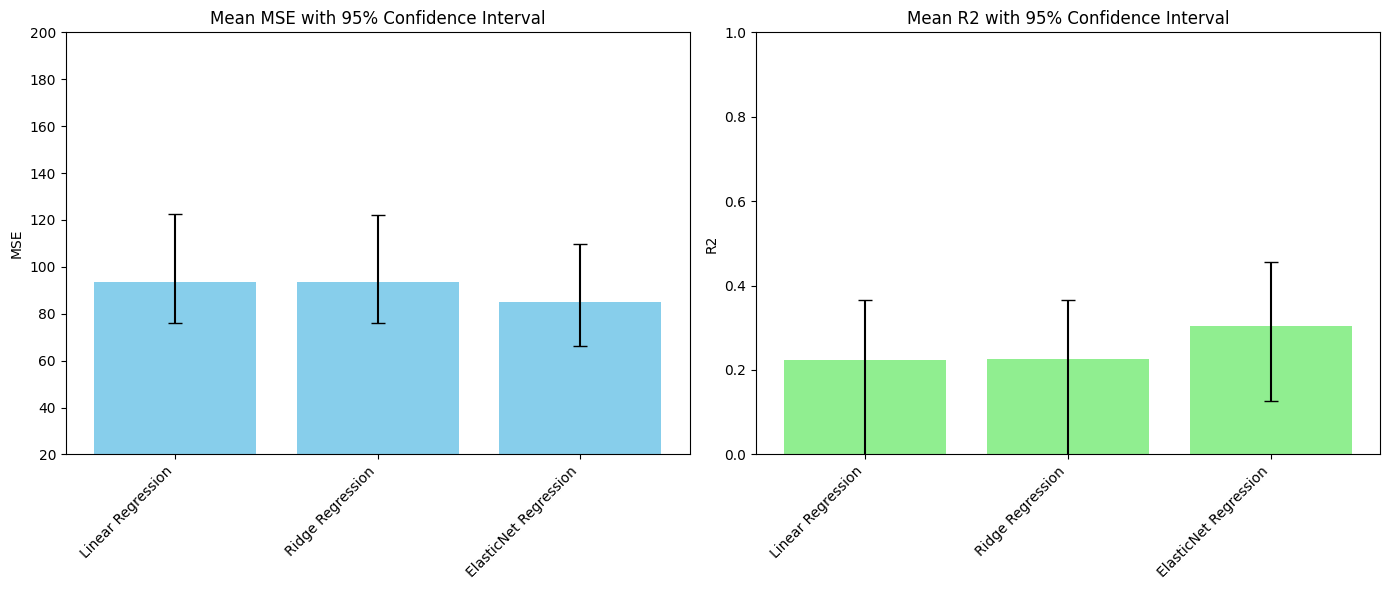

In [71]:
evaluation(LR_MSEs,LR_R2s,RR_MSEs,RR_R2s,ENR_MSEs,ENR_R2s)

#### 2- Women only

Mean MSE for Linear Regression: 81.4039767743786, 95% CI: [ 61.99474362 102.30060272]
Mean R2 for Linear Regression: 0.32655859857434866, 95% CI: [0.07109799 0.52107335]
-------------------------------------------------------------------------------------------------
Mean MSE for Ridge Regression: 81.26961196554569, 95% CI: [ 61.87980603 102.27423771]
Mean R2 for Ridge Regression: 0.3277495253969612, 95% CI: [0.07221842 0.52102313]
-------------------------------------------------------------------------------------------------
Mean MSE for ElasticNet Regression: 82.14879724899781, 95% CI: [ 65.95899767 102.71718425]
Mean R2 for ElasticNet Regression: 0.3258626266544995, 95% CI: [0.14689447 0.45795909]


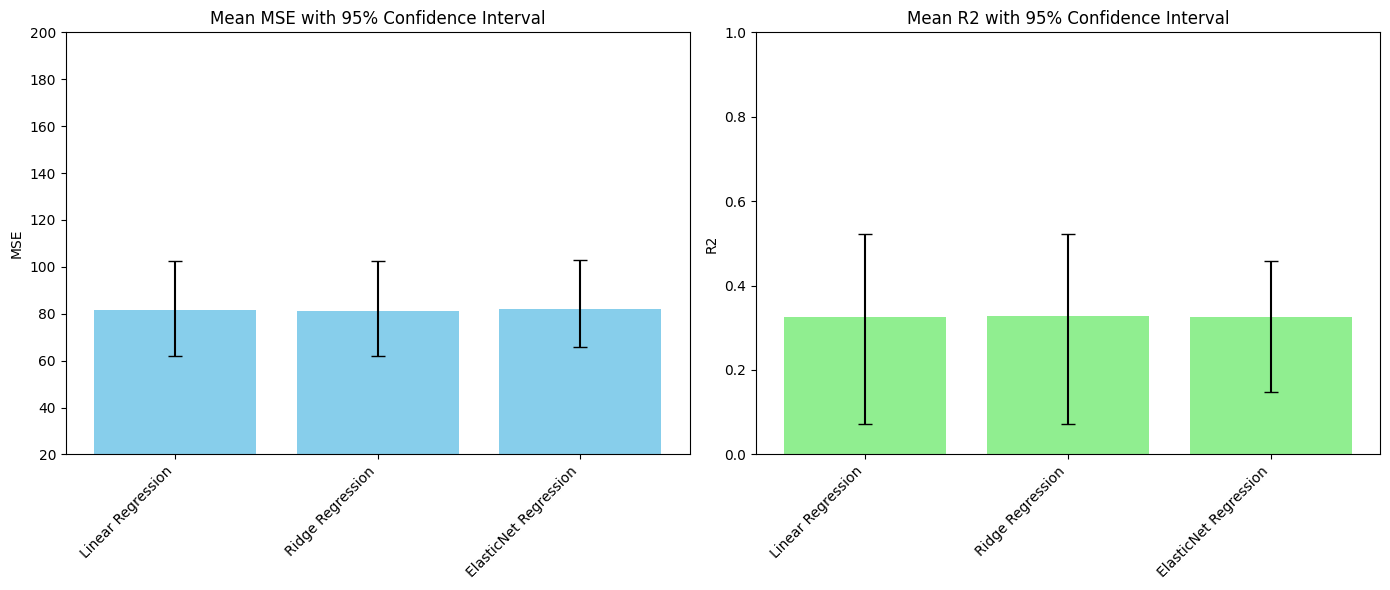

In [72]:
evaluation(f_LR_MSEs,f_LR_R2s,f_RR_MSEs,f_RR_R2s,f_ENR_MSEs,f_ENR_R2s)

#### 3- Men only

Mean MSE for Linear Regression: 134.5769243894009, 95% CI: [ 77.24690153 277.44700226]
Mean R2 for Linear Regression: -0.4490993665624063, 95% CI: [-1.73943844  0.3035828 ]
-------------------------------------------------------------------------------------------------
Mean MSE for Ridge Regression: 124.60972408899434, 95% CI: [ 75.26276249 244.97374347]
Mean R2 for Ridge Regression: -0.33927324390218344, 95% CI: [-1.46493756  0.30066489]
-------------------------------------------------------------------------------------------------
Mean MSE for ElasticNet Regression: 115.57231466443727, 95% CI: [ 75.20562135 168.87937051]
Mean R2 for ElasticNet Regression: -0.25273830383631973, 95% CI: [-1.23332149  0.28383753]


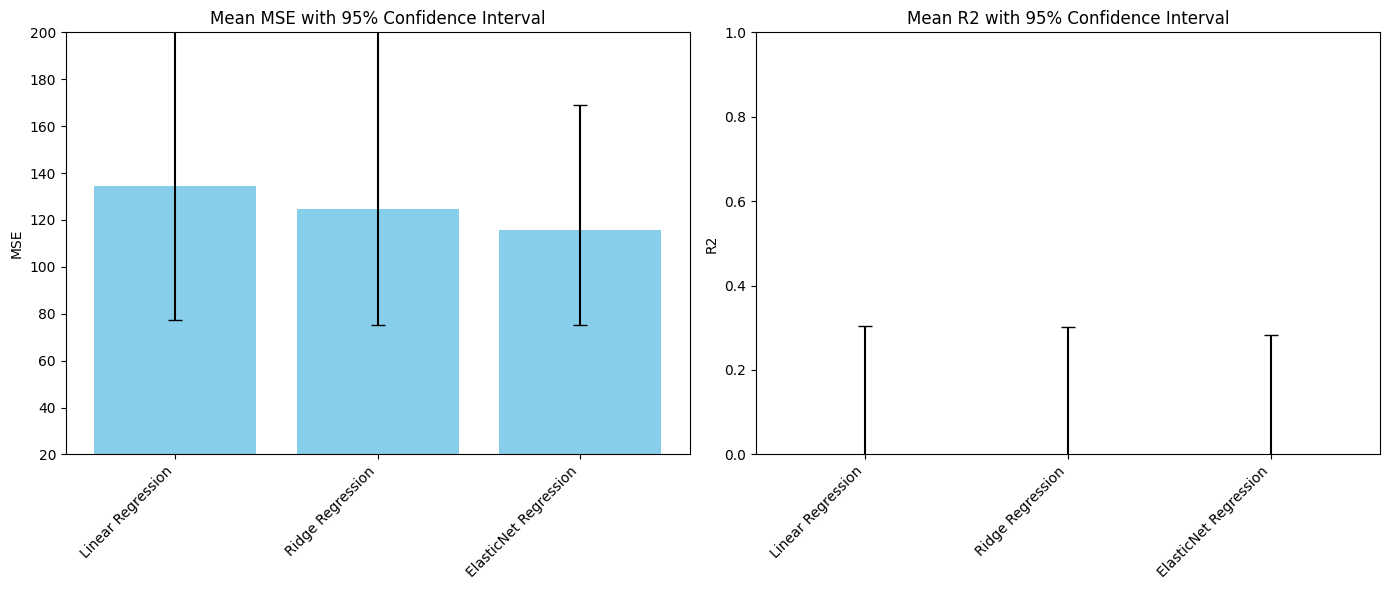

In [73]:
evaluation(m_LR_MSEs,m_LR_R2s,m_RR_MSEs,m_RR_R2s,m_ENR_MSEs,m_ENR_R2s)

As you can see, we were unable to achieve a satisfactory R² for any of the conditions. While it is biologically and computationally feasible to estimate human age based on gene expression data, our results suggest that the limited sample size was a significant factor in our lack of success. With fewer than 200 samples, there was insufficient data to effectively perform this regression task. Additionally, although we hypothesized that splitting the data based on sex might improve age prediction, this approach further reduced the number of samples (to fewer than 40 for men), making it impossible for us to accomplish our desired results.